In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# To process accented characters
import unicodedata

# NLTK
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


# from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# lemmatizer=WordNetLemmatizer()

# # SPACY
# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# spacy_model = spacy.load('en_core_web_sm')
# stopwords_spacy = spacy_model.Defaults.stop_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Overview

In [2]:
# Read in the csv file
df = pd.read_csv("../data/cuisine_full_ingredients.csv")

In [3]:
# Overview of the data set
df.sample(10, random_state=2)

,cuisine,recipe,full_ingredients
3727,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ..."
1923,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie..."
3552,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri..."
1146,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1..."
3195,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e..."
1643,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in..."
3054,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small..."
842,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz..."
505,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a..."
2224,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int..."


In [4]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cuisine           4724 non-null   object
 1   recipe            4724 non-null   object
 2   full_ingredients  4724 non-null   object
dtypes: object(3)
memory usage: 110.8+ KB


In [5]:
print(f"There are {df.cuisine.nunique()} cuisines represented in the dataset.")

There are 22 cuisines represented in the dataset.


In [6]:
# Get a list of unique cuisines
cuisine_list = df.cuisine.unique().tolist()

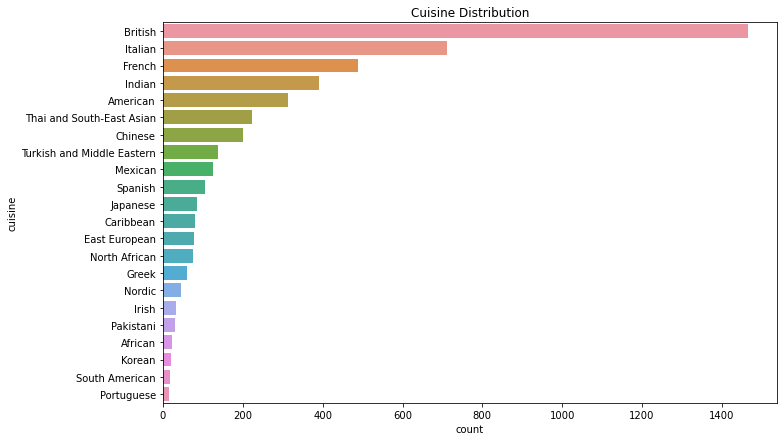

In [7]:
# Visualise cuisine distribution
y = df.cuisine
plt.figure(figsize=(11,7))
sns.countplot(y=y, order=y.value_counts().reset_index()["index"])
plt.title("Cuisine Distribution")
plt.show()

In [8]:
# Class distribution in the dataset
df.cuisine.value_counts()/df.shape[0]

British                       0.309907
Italian                       0.150720
French                        0.103302
Indian                        0.082769
American                      0.066046
Thai and South-East Asian     0.047417
Chinese                       0.042549
Turkish and Middle Eastern    0.029001
Mexican                       0.026461
Spanish                       0.022439
Japanese                      0.017993
Caribbean                     0.017146
East European                 0.016300
North African                 0.016088
Greek                         0.012913
Nordic                        0.009526
Irish                         0.006774
Pakistani                     0.006351
African                       0.004869
Korean                        0.004445
South American                0.003810
Portuguese                    0.003175
Name: cuisine, dtype: float64

As can be seen, the cuisine classification is imbalanced with the highest number of recipes in British cuisine. This can be explained because the data has been scraped from a website in uk. The top player is followed by Italian, French, and Indian cuisines. The least represented cuisines are the Korean, South American, and Portuguese recipes.

Let's take only column cuisine and full_ingredients

In [9]:
df = df[["cuisine", "full_ingredients"]]
df.shape

(4724, 2)

## Text cleaning

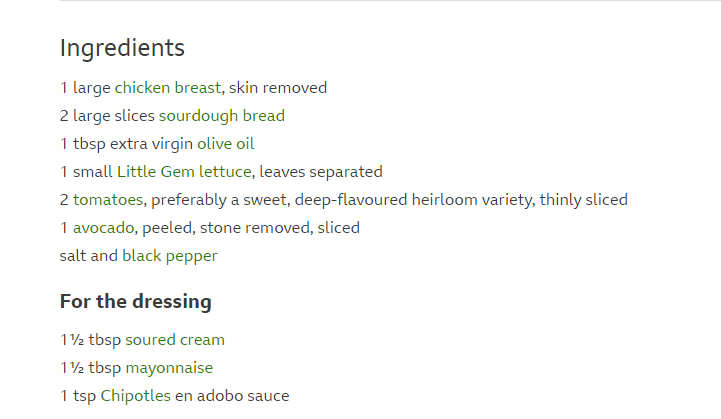
<div style="text-align: right"> (Image source: https://www.bbc.co.uk/food/recipes/californian_sourdough_59703) </div>

The above text image illustrates how a typical list of ingredients looks like. As I'm interested in a multi-class classification problem, I'd need to lowercase, remove special characters including digits, and text with digits, etc. As the data is from a well-known website, I assume that there are very few spelling errors.

In [10]:
# Convert to lowercase

df.full_ingredients = df.full_ingredients.str.lower()

### Special characters

In [11]:
# To investigate special characters (including digits) in the full_ingredients
## Let's firstly mix all text in the full_ingredients column into a list

[x for x in df.full_ingredients][:2]

["['2 large red or orange peppers, de-seeded and cut into bite-sized chunks', '2 sweet potatoes, scrubbed and cut into bite-sized chunks', '2 red onions, cut into bite-sized chunks', '200g/7oz cherry tomatoes', '1 tbsp harissa spice mix', '1 tbsp olive oil', 'sea salt and freshly ground black pepper']",
 "['350g/12oz dried black-eyed beans', '900g/2lb sirloin steak, cut into 1cm/½ in cubes', '325ml/11½fl oz vegetable oil', '1 large onion, chopped', '4 garlic cloves, finely chopped', '4cm/2in piece fresh root ginger, grated', '1 tsp dried chilli flakes', '2 x 400g tins chopped tomatoes', '2 tbsp tomato purée', '2 beef stock cubes', '2 sprigs fresh thyme', '1 scotch bonnet chilli, chopped', '3 ripe plantain, peeled and sliced', 'salt and freshly ground black pepper']"]

In [12]:
## Then seperate the texts into characters
characters = [char for ing_list in df.full_ingredients for char in ing_list]
characters[:15]

['[', "'", '2', ' ', 'l', 'a', 'r', 'g', 'e', ' ', 'r', 'e', 'd', ' ', 'o']

In [13]:
# Create a function to get unique special characters
def unique_special_chars():
    remaining_characters = [char for ing_list in df.full_ingredients for char in ing_list]
    outcome = ' '.join(sorted([char for char in set(
        remaining_characters) if re.findall('[^ a-z]', char)]))
    return outcome

In [14]:
# Get a set of unique characters, exclude a to z and whitespace, then sort them in order
unique_special_chars()

'! " % & \' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 : ; [ \\ ] ` £ ¼ ½ ¾ × â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ – ‘ ’ “ ” ⁄ ⅓ ⅔ ⅛ ⅜ ⅝'

Firstly, let's remove all of the digits (including fractions like `¼`) and words with digits (e.g. `900g/2lb`).

In [15]:
df.full_ingredients = df.full_ingredients.str.replace(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '')

Then remove the punctuations.

In [16]:
print(f"Possible punctuations to be removed {string.punctuation}")

Possible punctuations to be removed !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In the above list, `'` can be like quotation marks wrapping around an ingredient or apostrophes. Apostrophes `'` or `’` have three main uses:
1. To indicate possession
2. To indicate a word contraction (e.g. `do not` to `don't`)
3. To separate the s from plural letters/numbers and abbreviations followed by periods

As the dataset's main features are ingredient names (in noun form), word contraction should not be an issue. I'll simply drop `'` and `’`. Although this approach is not perfect, e.g. `lamb’s` will become `lambs`, I'll later apply another technique called stemming to map most of the different forms of a word to its base word.

In [17]:
# Create a function to get examples covering a character
def examples_for_character(rule):
    outcome = list(set([word for ing_list in df.full_ingredients for word in ing_list.split(
        " ") if re.findall(rule, word)]))
    return outcome

Following are some examples of some sets of characters with `'` or `’`

In [18]:
examples_for_character("['’]")[:30]

["jackfruit',",
 "gruyère',",
 "diced)',",
 "vinegar)',",
 "gherkin',",
 "well)',",
 "stilton',",
 "['a",
 "sage']",
 "pine',",
 "microwave',",
 "'",
 "'generous",
 "'snipped",
 "wings)',",
 "store)',",
 "powder',",
 "butter',",
 "picked',",
 "'crème",
 "delight']",
 "ricotta)\\t\\t',",
 "bashed',",
 "end',",
 "shell-on',",
 "beans']",
 "milk']",
 "bran',",
 "unwaxed',",
 "dampening',"]

In [19]:
# Remove punctuations
df.full_ingredients = df.full_ingredients.str.translate(str.maketrans('', '', string.punctuation))

In [20]:
# Review some ingredient text up to this step
[x for x in df.full_ingredients][:2]

[' large red or orange peppers deseeded and cut into bitesized chunks  sweet potatoes scrubbed and cut into bitesized chunks  red onions cut into bitesized chunks  cherry tomatoes  tbsp harissa spice mix  tbsp olive oil sea salt and freshly ground black pepper',
 ' dried blackeyed beans  sirloin steak cut into  in cubes  oz vegetable oil  large onion chopped  garlic cloves finely chopped  piece fresh root ginger grated  tsp dried chilli flakes  x  tins chopped tomatoes  tbsp tomato purée  beef stock cubes  sprigs fresh thyme  scotch bonnet chilli chopped  ripe plantain peeled and sliced salt and freshly ground black pepper']

Let's examine the remaining special characters.

In [21]:
unique_special_chars()

'£ × â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ – ‘ ’ “ ” ⁄'

Let's examine sets of characters with `£`, `×`, `–`, and `⁄`

In [22]:
examples_for_character("[£×–⁄]")

['litre–',
 '–',
 '⁄',
 'small–medium',
 'cm–',
 '––wide',
 'medium–hot',
 'oz–',
 '––',
 'medium–large',
 'self–raising',
 '£',
 'litres–',
 '×']

Similarly to my approach with ' as explained before, let's just trim `£`, `×`, `–`, and `⁄` from the above words.

In [23]:
df.full_ingredients = df.full_ingredients.str.replace(r'[£×–⁄]', '')

Next, let's examine words with `‘`, `’`, `“`, and `”` characters.

In [24]:
examples_for_character("[‘’“”]")

['ladies’',
 'd’ambert',
 'can’t',
 'za’atar',
 'bird’seye',
 'cox’s',
 '“flats”',
 '“”',
 '“drumettes”',
 '‘liquid',
 '‘feed’',
 'don’t',
 'cows’',
 'd’auvergne',
 '‘picante’',
 '’nduja',
 'bird’s',
 'pimm’s',
 'birds’eye',
 'smoke’',
 'sheeps’',
 'bull’s',
 'you’d',
 '‘’',
 'paste’',
 '‘butter’',
 'calf’s',
 'cow’s',
 'monk’s',
 'jacob’s',
 'pig’s',
 'quails’',
 'gentleman’s',
 '‘ladyfinger’',
 '‘gluelike',
 'doesn’t',
 'd’espelette',
 '‘milk’',
 '‘suyannaise’',
 'lamb’s',
 'd’or',
 'goats’',
 'man’s',
 'butt”',
 'cheese’',
 'goat’s',
 '‘mozzarellastyle’',
 'lambs’',
 '“boston',
 '‘medium’',
 'sheep’s',
 '‘cream']

Similarly to my approach with `'` as explained before, let's just trim `‘`, `’`, `“`, and `”` from the above words.

In [25]:
df.full_ingredients = df.full_ingredients.str.replace(r'[‘’“”]', '')

Let's examine the remaining special characters.

In [26]:
unique_special_chars()

'â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ'

Let's have a closer look at words that have characters `â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ`

In [27]:
examples_for_character("[âãäçèéêîïñóôûüōưấớ]")

['créme',
 'soufflé',
 'puréed',
 'velouté',
 'compôte',
 'flambé',
 'pâté',
 'padrón',
 'suprêmes',
 'frâiche',
 'croûtons',
 'niçoise',
 'jalapeños',
 'flambéeing',
 'spreadpurée',
 'ñora',
 'chấm',
 'pureé',
 'aïoli',
 'purèe',
 'ximénez',
 'desirée',
 'shōga',
 'crêpes',
 'sautéed',
 'ibérico',
 'crème',
 'rosé',
 'pouillyfumé',
 'glacé',
 'gruyére',
 'cépe',
 'gewürztraminer',
 'nước',
 'pimentão',
 'jamón',
 'pimentón',
 'frisée',
 'épices',
 'patissière',
 'consommé',
 'béchamel',
 'jalapeño',
 'comté',
 'désirée',
 'purée',
 'glacés',
 'côte',
 'pressé',
 'gruyère',
 'fraîche',
 'fraïche',
 'västerbotten']

The above words have [accented characters](https://www.fonts.com/content/learning/fontology/level-3/signs-and-symbols/accents). They are important elements in both written and spoken language. They might be considered as "borrowed" words in English, sometimes helping to clarify the meaning of a word which might be different without the accent. Accents might get induced due to a keyboard default setting or typing style. As I'm analysing text in English, it would be more helpful to convert these words into ASCII characters. 

In [28]:
# Create a function to remove accented characters
def remove_accented_chars(matchobj):
    text = matchobj.group()
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

In [29]:
# Remove accented characters in the full_ingredients
df.full_ingredients = df.full_ingredients.apply(
    lambda x: re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, x))

In [30]:
# Try some random examples to test
print(f"The number of word 'pureé' is {df.full_ingredients.str.contains('pureé').sum()}.")
print(f"The number of word 'puree' is {df.full_ingredients.str.contains('puree').sum()}.")
print(f"The number of word 'jalapeños' is {df.full_ingredients.str.contains('jalapeños').sum()}.")
print(f"The number of word 'jalapenos' is {df.full_ingredients.str.contains('jalapenos').sum()}.")

The number of word 'pureé' is 0.
The number of word 'puree' is 337.
The number of word 'jalapeños' is 0.
The number of word 'jalapenos' is 4.


In [31]:
# Check remaining special characters
unique_special_chars()

''

There are no special characters left.

## Pre-Processing

### Word tokenization

In [32]:
df.full_ingredients = df.full_ingredients.apply(lambda x: word_tokenize(x))
df.full_ingredients[:10]

0    [large, red, or, orange, peppers, deseeded, an...
1    [dried, blackeyed, beans, sirloin, steak, cut,...
2    [oz, olive, oil, onion, chopped, garlic, clove...
3    [butter, for, greasing, oz, fullfat, milk, fre...
4    [tbsp, olive, oil, onion, thinly, sliced, garl...
5    [tbsp, vegetable, oil, tsp, cumin, seeds, tsp,...
6    [tsp, cloves, tsp, fennel, seeds, tsp, black, ...
7    [tbsp, olive, oil, large, onions, sliced, bone...
8    [peppercorns, cardamom, pods, cloves, tbsp, oi...
9    [salt, tsp, coriander, seeds, tsp, fennel, see...
Name: full_ingredients, dtype: object

### Remove stop words

In [33]:
df.full_ingredients = df.full_ingredients.apply(lambda x: [word for word in x if not word in stop_words_nltk])
df.full_ingredients[:10]

0    [large, red, orange, peppers, deseeded, cut, b...
1    [dried, blackeyed, beans, sirloin, steak, cut,...
2    [oz, olive, oil, onion, chopped, garlic, clove...
3    [butter, greasing, oz, fullfat, milk, fresh, w...
4    [tbsp, olive, oil, onion, thinly, sliced, garl...
5    [tbsp, vegetable, oil, tsp, cumin, seeds, tsp,...
6    [tsp, cloves, tsp, fennel, seeds, tsp, black, ...
7    [tbsp, olive, oil, large, onions, sliced, bone...
8    [peppercorns, cardamom, pods, cloves, tbsp, oi...
9    [salt, tsp, coriander, seeds, tsp, fennel, see...
Name: full_ingredients, dtype: object

### Stemming
Stemming refers to the process of removing suffixes and reducing all different variants of a word to some base form (e.g., “lamb” and “lambs” are both reduced to “lamb”). Stemming is commonly used in text classification to reduce the feature space to train machine learning models.

In [34]:
df.full_ingredients = df.full_ingredients.apply(lambda x: [stemmer.stem(word) for word in x])
df.full_ingredients[:10]

0    [larg, red, orang, pepper, deseed, cut, bites,...
1    [dri, blackey, bean, sirloin, steak, cut, cube...
2    [oz, oliv, oil, onion, chop, garlic, clove, cr...
3    [butter, greas, oz, fullfat, milk, fresh, whit...
4    [tbsp, oliv, oil, onion, thinli, slice, garlic...
5    [tbsp, veget, oil, tsp, cumin, seed, tsp, fenn...
6    [tsp, clove, tsp, fennel, seed, tsp, black, mu...
7    [tbsp, oliv, oil, larg, onion, slice, boneless...
8    [peppercorn, cardamom, pod, clove, tbsp, oil, ...
9    [salt, tsp, coriand, seed, tsp, fennel, seed, ...
Name: full_ingredients, dtype: object

In bags of words, bags of n-grams, or CountVectorizer approaches, all of the words in the text are treated equally important. TF-IDF, meanwhile, emphasizes that some words in a document are more important than others. For the current classification problem, I find that TF-IDF would suit the best. As the TF-IDF Vectorizer expects an array of strings, I'll create a new column in the dataframe joining ingredient tokens for each recipe into an array of strings. 

In [35]:
df["ingredients_processed"] = df.full_ingredients.apply(lambda x: ' '.join([word for word in x]))
df.head()

,cuisine,full_ingredients,ingredients_processed
0,African,"[larg, red, orang, pepper, deseed, cut, bites,...",larg red orang pepper deseed cut bites chunk s...
1,African,"[dri, blackey, bean, sirloin, steak, cut, cube...",dri blackey bean sirloin steak cut cube oz veg...
2,African,"[oz, oliv, oil, onion, chop, garlic, clove, cr...",oz oliv oil onion chop garlic clove crush lamb...
3,African,"[butter, greas, oz, fullfat, milk, fresh, whit...",butter greas oz fullfat milk fresh white bread...
4,African,"[tbsp, oliv, oil, onion, thinli, slice, garlic...",tbsp oliv oil onion thinli slice garlic clove ...


## Modeling

### Split the data into training and test sets (75% train, 25% test)

In [36]:
X = df.ingredients_processed #the column contains textual data to extract features from.
y = df.cuisine #the column we're learning to predict.
print(X.shape, y.shape)

(4724,) (4724,)


In [37]:
# Split X and y into training and testing sets. By default, it splits 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3543,) (3543,)
(1181,) (1181,)


### Feature engineering using TF-IDF

In [38]:
tfidf = TfidfVectorizer()

In [39]:
# Vectorize train and test data
X_train_transformed = tfidf.fit_transform(X_train)
X_test_transformed = tfidf.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(3543, 2941) (1181, 2941)


The dimension of our feature vector is now 2941.

In [40]:
label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)

### Model building

#### Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB

In [42]:
#instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_train_transformed, y_train_transformed)

MultinomialNB()

In [43]:
# Make class predictions for X_test_transformed
y_predicted = nb.predict(X_test_transformed)
y_predicted_inversed = label_encoder.inverse_transform(y_predicted)

In [44]:
#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

In [45]:
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_predicted_inversed))

Accuracy:  0.5207451312447079


In [56]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

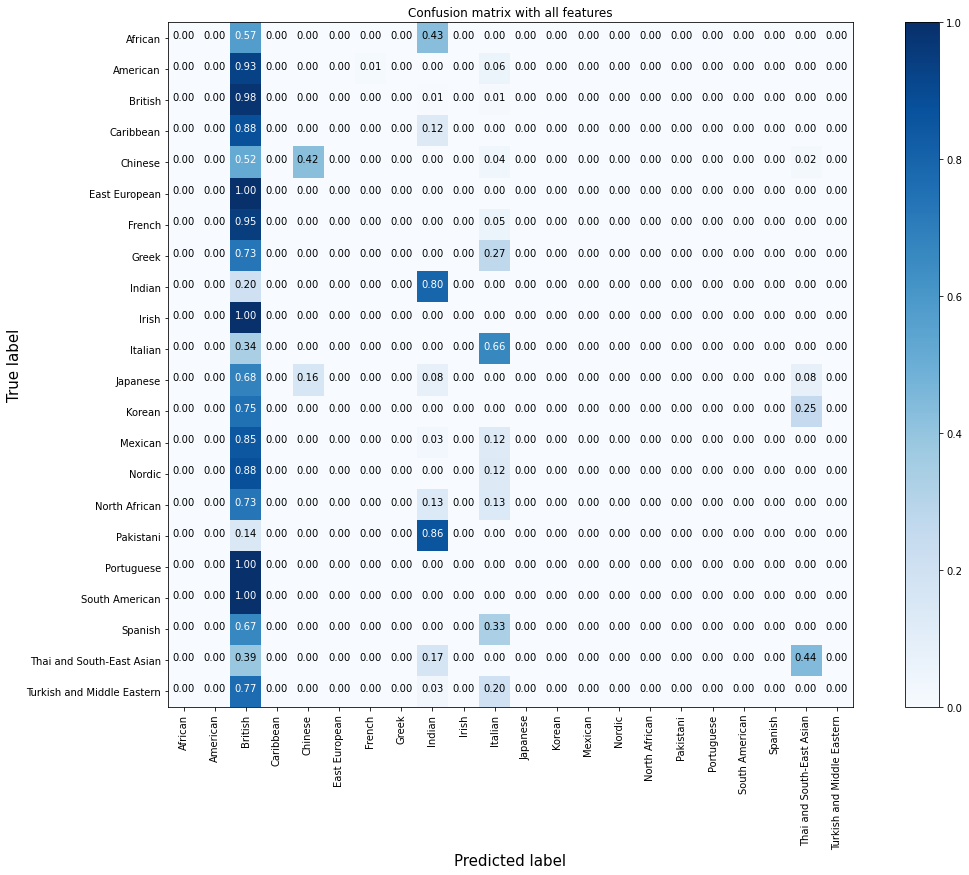

In [57]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted_inversed)
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cnf_matrix, classes=cuisine_list, normalize=True,
                      title='Confusion matrix with all features')

As expected, due to the dataset imbalance, most recipes are predicted as British cuisines.

In [58]:
# Calculate classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted_inversed,
                            target_names=cuisine_list))

                            precision    recall  f1-score   support

                   African       0.00      0.00      0.00         7
                  American       0.00      0.00      0.00        83
                   British       0.43      0.98      0.59       365
                 Caribbean       0.00      0.00      0.00        16
                   Chinese       0.85      0.42      0.56        52
             East European       0.00      0.00      0.00        16
                    French       0.00      0.00      0.00       110
                     Greek       0.00      0.00      0.00        22
                    Indian       0.71      0.80      0.75        88
                     Irish       0.00      0.00      0.00         5
                   Italian       0.76      0.66      0.71       211
                  Japanese       0.00      0.00      0.00        25
                    Korean       0.00      0.00      0.00         4
                   Mexican       0.00      0.00

C:\Users\Boss\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
